In [65]:
import pandas as pd
import cerberus
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [31]:
def parse_meta(species):
    df = pd.read_csv(f'data/{species}/metadata.tsv', sep='\t')
    df['species'] = species
    df['subset'] = subset
    df['dataset'] = df['tissue']+'_'+\
                 df['age']+'_'+\
                 df['platform']+'_'+\
                 df['capture']+'_'+\
                 df['species']+'_'+\
                 df['subset']
    
    return df

In [56]:
DEBUG = True

## Capture vs. non capture triplets


capture=post-capture
523659
372434

n_tss
70.46% (20933/29711) of genes have >1 tss
n_ic
69.88% (20761/29711) of genes have >1 ic
n_tes
60.34% (17927/29711) of genes have >1 tes
n_iso
79.58% (23643/29711) of genes have >1 iso

capture=pre-capture
523659
245329

n_tss
70.12% (19416/27690) of genes have >1 tss
n_ic
73.07% (20232/27690) of genes have >1 ic
n_tes
60.20% (16668/27690) of genes have >1 tes
n_iso
80.56% (22306/27690) of genes have >1 iso


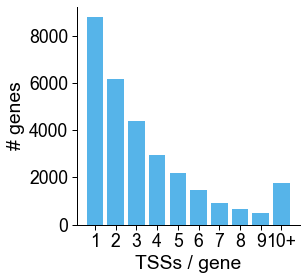

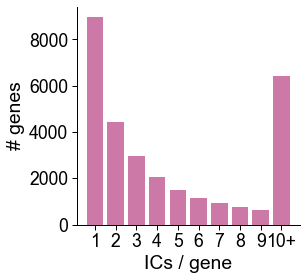

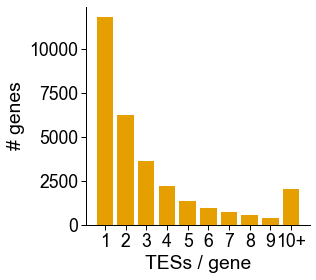

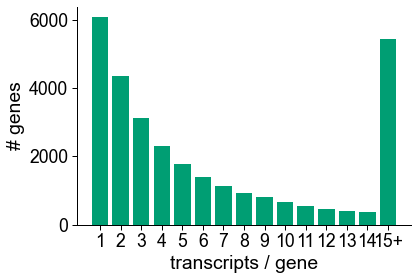

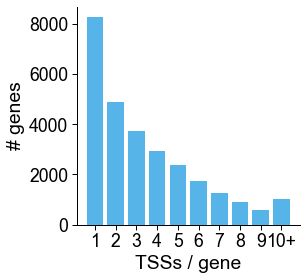

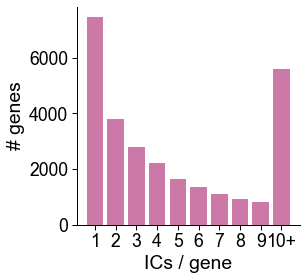

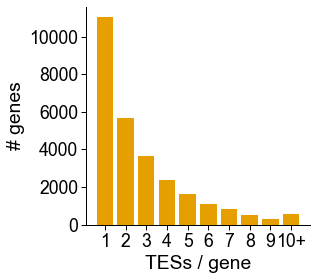

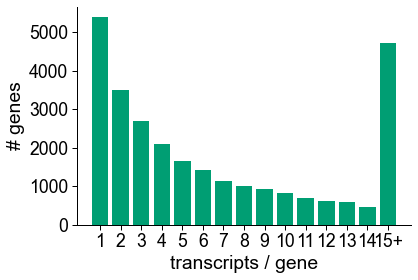

In [146]:
species = 'human'
obs_col = 'capture'
min_tpm = 1

ca = cerberus.read(f'data/{species}/cerberus/ca_trip.h5')
df = pd.read_csv(f'data/{species}/cerberus/agg_ab.tsv', sep='\t')
df.drop('annot_transcript_name', axis=1, inplace=True)
df.set_index('annot_transcript_id', inplace=True)
df = df.transpose()
df = df.fillna(0)
meta = parse_meta(species)
meta_cols = meta.columns
df = df.merge(meta, how='left', left_index=True, right_on='dataset')
df.drop([c for c in meta_cols if c != obs_col], axis=1, inplace=True)

# groupby and take max tpm value per thing
df = df.groupby('capture').max().reset_index()

# loop through the different conditions
trip = pd.DataFrame()
for obs_cond in df[obs_col].unique():
    print()
    print(f'{obs_col}={obs_cond}')
    source = f'{obs_col}_{obs_cond}'
    temp = df.loc[df[obs_col] == obs_cond].copy(deep=True)
    temp = temp.drop(obs_col, axis=1).transpose()
    temp.columns = ['max_tpm']
    if DEBUG: print(len(temp.index))
    temp = temp.loc[temp.max_tpm >= min_tpm]
    if DEBUG: print(f'{len(temp.index)}\n')
    tids = temp.index.tolist()
    temp_trip = ca.get_subset_triplets(tids, source)
    _ = plot_feats_per_gene(temp_trip,
                            obs_cond,
                            max_ends=10)
    trip = pd.concat([trip, temp_trip], axis=0)

In [127]:
trip.head()

,gene_id,n_iso,n_tss,n_ic,n_tes,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,source
0,ENSG00000000003,8,4,4,2,1.333333,0.545455,0.272727,0.181818,tss,capture_post-capture
1,ENSG00000000005,1,1,1,1,1.000000,0.333333,0.333333,0.333333,simple,capture_post-capture
2,ENSG00000000419,7,3,6,2,2.400000,0.405405,0.270270,0.324324,mixed,capture_post-capture
3,ENSG00000000457,1,1,1,1,1.000000,0.333333,0.333333,0.333333,simple,capture_post-capture
4,ENSG00000000938,2,2,1,1,0.666667,0.545455,0.272727,0.181818,tss,capture_post-capture


In [115]:
feat = 'tss'
df = trip.copy(deep=True)
max_ends = 10

In [144]:
def get_talon_nov_colors(cats=None):
    c_dict = {'Known': '#009E73',
              'ISM': '#0072B2',
              'ISM_rescue': '#0072B2',
              'NIC': '#D55E00',
              'NNC': '#E69F00',
              'Antisense': '#000000',
              'Intergenic': '#CC79A7',
              'Genomic': '#F0E442'}
    order = ['Known', 'ISM', 'ISM_rescue', 'NIC', 'NNC', 'Antisense', 'Intergenic', 'Genomic']

    c_dict, order = rm_color_cats(c_dict, order, cats)
    return c_dict, order


def rm_color_cats(c_dict, order, cats):
    if cats:
        keys = c_dict.keys()
        pop_list = []
        for key in keys:
            if key not in cats:
                pop_list.append(key)
        for p in pop_list:
            del c_dict[p]
        order = [o for o in order if o in cats]
    return c_dict, order

def get_shade_colors(color, order):
    c_dict = {}
    min_color = '#FFFFFF'
    cmap = mpl.colors.LinearSegmentedColormap.from_list('temp', [color, min_color], N=len(order)+1)
    for i, cat in enumerate(order):
        c_dict[cat] = mpl.colors.to_hex(cmap(i))

    return c_dict, order

def get_sector_colors(cats=None):
    tss = '#56B4E9'
    tes = '#E69F00'
    splicing = '#CC79A7'
    simple = '#000000'
    c_dict = {'tss': tss,
              'splicing': splicing,
              'tes': tes,
              'simple': simple,
              'mixed': '#b7b7b7'}
    order = ['tss', 'splicing', 'tes', 'mixed', 'simple']

    c_dict, order = rm_color_cats(c_dict, order, cats)
    return c_dict, order

def plot_feats_per_gene(df,
                        obs_cond,
                        max_ends=10):
    dfs = {}
    for feat in ['tss', 'ic', 'tes', 'iso']:
        if feat == 'iso':
            temp_max_ends = 15
        else:
            temp_max_ends = 10
        dfs[feat] = plot_n_feat_per_gene(df, feat, obs_cond, temp_max_ends)
        
    # what percentage of polya genes have more than one triplet feature / gene? 
    for feat in ['tss', 'ic', 'tes', 'iso']:
        df = dfs[feat]    
        df['total'] = df['protein_coding']
        col = f'n_{feat}'
        print(col)
        df['one_feat'] = (df[col] == '1')
        temp = df[['total', 'one_feat']].groupby('one_feat').sum().reset_index()

        n = temp.total.sum(axis=0)
        n_num = temp.loc[temp.one_feat==False, 'total'].values[0]
        print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) of genes have >1 {feat}')
        
    return dfs

def plot_n_feat_per_gene(df,
                         feat,
                         obs_cond,
                         max_ends=10):

    sns.set_context('paper', font_scale=2)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    if max_ends == 10:
        w = 4
    elif max_ends == 15:
        w = 6
    plt.figure(figsize=(w,4))

    c_dict, order = get_sector_colors()
    if feat == 'ic':
        c = c_dict['splicing']
    elif feat == 'iso':
        c_dict, order = get_talon_nov_colors(cats=['Known'])
        c = c_dict['Known']
    else:
        c = c_dict[feat]

    c_dict, order = get_shade_colors(c, ['protein_coding'])

    # count up number of genets per # features
    feat_col = f'n_{feat}'
    df = df[['gene_id', feat_col]]
    df.loc[df[feat_col] >= max_ends, feat_col] = f'{max_ends}+'
    df = df.groupby(feat_col).count().reset_index().rename({'gene_id': 'protein_coding'}, axis=1)
    df[feat_col] = df[feat_col].astype(str)
    x = df[feat_col].unique().tolist()

    b_dict = {'protein_coding': 'Protein coding'}

    # loop through biotypes
    bottom = [0 for i in range(len(x))]
    for b in order:
        y = df[b].tolist()
        plt.bar(x, y, color=c_dict[b], bottom=bottom)
        bottom = [b_coord+y_coord for b_coord, y_coord in zip(bottom, y)]

    if feat != 'iso':
        feat_name = feat.upper()
    else:
        feat_name = 'transcript'
    xlabel = f'{feat_name}s / gene'
    plt.xlabel(xlabel)
    plt.ylabel('# genes')
    sns.despine()

    # leg_labels = [b_dict[o] for o in order]
    # plt.legend(leg_labels, bbox_to_anchor=(.6, 1.05))
    # ax = plt.gca()
    # leg = ax.get_legend()
    # shade_dict, _ = get_shade_colors('#000000', order)
    # for i, o in enumerate(order):
    #     leg.legendHandles[i].set_color(shade_dict[o])

    fname = f'figures/{obs_cond}_{feat}_per_gene_support.png'
    plt.savefig(fname, dpi=500, bbox_inches='tight')

    fname = 'figures/{}_per_gene_support.pdf'.format(feat)
    plt.savefig(fname, dpi=500, bbox_inches='tight')

    return df

n_tss
70.29% (40349/57401) of protein coding genes have >1 tss
n_ic
71.42% (40993/57401) of protein coding genes have >1 ic
n_tes
60.27% (34595/57401) of protein coding genes have >1 tes
